In [ ]:
!pip install yfinance --quiet
!pip install QuantLib-Python --quiet
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import QuantLib as ql
from sklearn.linear_model import LinearRegression

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.6/19.6 MB 22.0 MB/s eta 0:00:00


In [ ]:
INITIAL_FIXING_DATE = "2023-09-15"
INITIAL_INVESTMENT = 1000  # Investment amount in CHF
TICKER = "STMN.SW"
START_DATE = "2023-09-14" # for log return calculation, we need data from 1 day before
END_DATE = "2024-11-06" # since we only have risk free rate till this date, written on 07/11/2024
initial_price = 129.25 # initial stock price
conversion_ratio = 7.73694 # number of underlying

underlying_asset_data = yf.download(TICKER, start=START_DATE, end=END_DATE)['Adj Close']
barrier_level = 77.55 # Given by termsheet

# https://www.calendarlabs.com/market-business-days
TOTAL_DAYS = 289 # number of days from initial fixing date to current date - 5 Nov 2024
WINDOW_SIZE = 204 # so that we start calculating payoff on 8 July 2024
T = 383 # number of trading days from initial fixing date to final fixing date

# Rates taken based on Saron
risk_free_rate_series = pd.read_csv("/content/rates Saron.csv")["Saron rates"]/100

coupon_dates = [72, 133, 193, 258, 322]
monitoring_dates = [253, 318] # payment date will be 5 time step after monitoring date

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Discount factor should be from rates term structure, but I'll use interest rate for simplicity
def get_sliding_window_params(underlying_asset_data, risk_free_rate_series, i, total_days=TOTAL_DAYS):
  # i is the number of days away from current date
    start_idx = max(0, total_days - WINDOW_SIZE - i)
    end_idx = total_days - i
    window_data = underlying_asset_data.iloc[start_idx:end_idx]

    log_returns = np.log(window_data / window_data.shift(1)).dropna() # to find mean and std. of asset in each window, first entry will be dropped
    drift = log_returns.mean().values
    sigma = log_returns.std().values * np.sqrt(252)
    risk_free_rate = risk_free_rate_series.iloc[start_idx] # index 0 gives risk free rate for 8 July 2024
    latest_underlying_asset_price = window_data.iloc[-1]

    return drift, sigma[0], latest_underlying_asset_price.values[0], risk_free_rate

In [ ]:
def gbm_with_emc(Nsim, S0_window, r, sigma, T_minus_t):
    dt = 1/252
    steps = T_minus_t

    paths = np.zeros((Nsim, steps + 1))
    paths[:, 0] = S0_window

    Z = np.random.normal(0, 1, (Nsim, steps))
    for t in range(1, steps + 1):
        paths[:, t] = paths[:, t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z[:, t - 1])
    S_corrected = np.zeros_like(paths)
    S_corrected[:, 0] = S0_window

    # empirical martingale correction, to reduce discretization error
    for j in range(1, steps + 1):
        Z_matrix = S_corrected[:, j - 1] * paths[:, j] / paths[:, j - 1]
        correction_factor = np.exp(-r * (j * dt)) * np.mean(Z_matrix)
        S_corrected[:, j] = S0_window * Z_matrix / correction_factor

    return S_corrected

In [ ]:
def gbm_with_antithetic(Msim, S0_window, r, sigma, T_minus_t):
    dt = 1/252
    steps = T_minus_t
    paths = np.zeros((Nsim, steps + 1))
    paths_antithetic = np.zeros((Nsim, steps + 1))
    paths[:, 0] = S0_window
    paths_antithetic[:, 0] = S0_window
    Z = np.random.normal(0, 1, (Nsim, steps))

    # negative covariance to reduce variance. emc to reduce discretization error
    for t in range(1, steps + 1):
        paths[:, t] = paths[:, t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z[:, t - 1])
        paths_antithetic[:, t] = paths_antithetic[:, t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt - sigma * np.sqrt(dt) * Z[:, t - 1])
    paths_combined = np.vstack((paths, paths_antithetic))

    return paths_combined

In [26]:
def calculate_discounted_payoff(
    paths, barrier_level, initial_price, conversion_ratio, r, T_minus_t,
    adjusted_coupon_dates, adjusted_monitoring_dates, initial_investment=1000
):
    num_paths, num_steps = paths.shape
    dt = 1 / 252  # Time step size, number of trading days in a year is 252
    discount_factor = np.exp(-r * dt)  # Discount factor for one time step
    V = np.zeros((num_paths, num_steps))  # Payoff matrix
    discounted_payoff = np.zeros(num_paths)  # To store all the payoffs
    coupon_rate = 1.8125 / 100  # Coupon rate per period
    coupon_payment = coupon_rate * initial_investment  # Coupon payment per period

    # Convert adjusted dates to NumPy and filter out past dates, then get discounted coupons
    adjusted_coupon_dates = np.array(adjusted_coupon_dates)
    adjusted_monitoring_dates = np.array(adjusted_monitoring_dates)
    coupon_dates_from_today = adjusted_coupon_dates[adjusted_coupon_dates >= 0]
    monitoring_dates_from_today = adjusted_monitoring_dates[adjusted_monitoring_dates >= 0]
    discounted_coupons = np.zeros(num_steps)
    for t_coupon in coupon_dates_from_today:
        time_to_coupon = t_coupon * dt  # Time from today to coupon date
        discounted_coupons[t_coupon] = coupon_payment * np.exp(-r * time_to_coupon)
    cumulative_discounted_coupons = np.cumsum(discounted_coupons)

    # array to track of paths that have been redeemed
    redeemed = np.zeros(num_paths, dtype=bool)

    # Perform backward induction, this is for least square monte carlo method
    for t in range(num_steps - 1, -1, -1):
        if t == num_steps - 1: # terminal payoff
            for i in range(num_paths):
                path = paths[i, :]
                zero_hit = np.any(path == 0)
                barrier_breached = np.any(path <= barrier_level)
                final_price = path[-1]

                if zero_hit:
                    V[i, t] = 0  # Hit zero
                else:
                    if barrier_breached:
                        if final_price >= initial_price:
                            V[i, t] = initial_investment  # Full redemption
                        else:
                            V[i, t] = conversion_ratio * final_price # Converted to stock, multiplied by stock's final price to find the value
                    else:
                        V[i, t] = initial_investment  # Barrier not breached, full redemption

                # Add final coupon payment, as it is not in the adjusted_coupon_dates
                V[i, t] += coupon_payment
        else:
            # Discount the future payoff
            V[:, t] = V[:, t + 1] * discount_factor

            # Add coupon payment if t is a coupon date
            if t in coupon_dates_from_today:
                V[:, t] += coupon_payment

            # Handle zero hits
            zero_indices = np.where(paths[:, t] == 0)[0]
            V[zero_indices, t] = 0
            redeemed[zero_indices] = True

    # Process monitoring dates from earlier date to latest date
    for t in monitoring_dates_from_today:
        if t >= 0 and t < num_steps:
            paths_to_consider = (~redeemed)
            indices = np.where(paths_to_consider)[0]

            if len(indices) > 0:
                S_t = paths[indices, t]
                itm_in_indices = np.where(S_t >= initial_price)[0] # Paths where the issuer might consider calling
                itm_indices = indices[itm_in_indices]

                if len(itm_indices) > 0:
                    # Regression to estimate continuation value
                    X = S_t[itm_in_indices].reshape(-1, 1)
                    Y = V[itm_indices, t]  # Value at time t from backward induction
                    X_poly = np.hstack((np.ones_like(X), X, X**2))
                    model = LinearRegression(fit_intercept=False) # fitting regression model
                    model.fit(X_poly, Y)
                    continuation_value = model.predict(X_poly) # estimate based on regression
                    payment_date = t + 5 # Redemption occurs 5 time steps after monitoring date
                    time_to_payment = (payment_date - t) * dt
                    discount_payment = np.exp(-r * time_to_payment)
                    immediate_exercise_value = (initial_investment + coupon_payment) * discount_payment

                    # Early exercise decision (assuming issuer exercises when immediate cost <= continuation value)
                    exercise = immediate_exercise_value <= continuation_value
                    exercise_indices_in_itm = np.where(exercise)[0]
                    exercise_indices = itm_indices[exercise_indices_in_itm]

                    # Update discounted payoff for exercised paths
                    discounted_payoff[exercise_indices] = initial_investment * np.exp(-r * t * dt) + cumulative_discounted_coupons[payment_date]
                    redeemed[exercise_indices] = True

    # For paths not redeemed early, use terminal value to get payoff
    non_redeemed_indices = np.where(~redeemed)[0]
    if len(non_redeemed_indices) > 0:
        discounted_payoff[non_redeemed_indices] = V[non_redeemed_indices, -1] * np.exp(-r * T_minus_t * dt) + cumulative_discounted_coupons[-1]

    # Expected payoff is the average of the payoffs
    expected_payoff = np.mean(discounted_payoff)

    return expected_payoff

In [ ]:
def simulate_payoffs(Nsim, Msim, underlying_asset_data, risk_free_rate_series, total_days=TOTAL_DAYS, window_size=WINDOW_SIZE, T=T,
                     coupon_dates = coupon_dates, monitoring_dates = monitoring_dates):
    results_emc = []
    results_an = []
    max_i = total_days - window_size

    # this loop so that end index = window_size for first iteration and end index increases as it iterates
    for i in range(max_i, -1, -1):
        drift, sigma, latest_price, risk_free_rate = get_sliding_window_params(
            underlying_asset_data, risk_free_rate_series, i, total_days
        )
        T_minus_t = T - (total_days - i)

        adjusted_coupon_dates = [date - (total_days - i) for date in coupon_dates]
        adjusted_monitoring_dates = [date - (total_days - i) for date in monitoring_dates]

        paths_emc = gbm_with_emc(Nsim, latest_price, risk_free_rate, sigma, T_minus_t)
        paths_an = gbm_with_antithetic(Msim, latest_price, risk_free_rate, sigma, T_minus_t)

        expected_payoff_emc = calculate_discounted_payoff(paths_emc, barrier_level, initial_price, conversion_ratio, risk_free_rate, T_minus_t,
                                    adjusted_coupon_dates, adjusted_monitoring_dates, initial_investment=INITIAL_INVESTMENT)
        expected_payoff_an = calculate_discounted_payoff(paths_an, barrier_level, initial_price, conversion_ratio, risk_free_rate, T_minus_t,
                                    adjusted_coupon_dates, adjusted_monitoring_dates, initial_investment=INITIAL_INVESTMENT)

        # Store the result
        results_emc.append(expected_payoff_emc)
        results_an.append(expected_payoff_an)

    return results_emc, results_an

In [ ]:
results_actual = pd.read_excel("/content/Actual Price.xlsx")["Mid"] * (1000/100) # values of actual price are in terms of % price

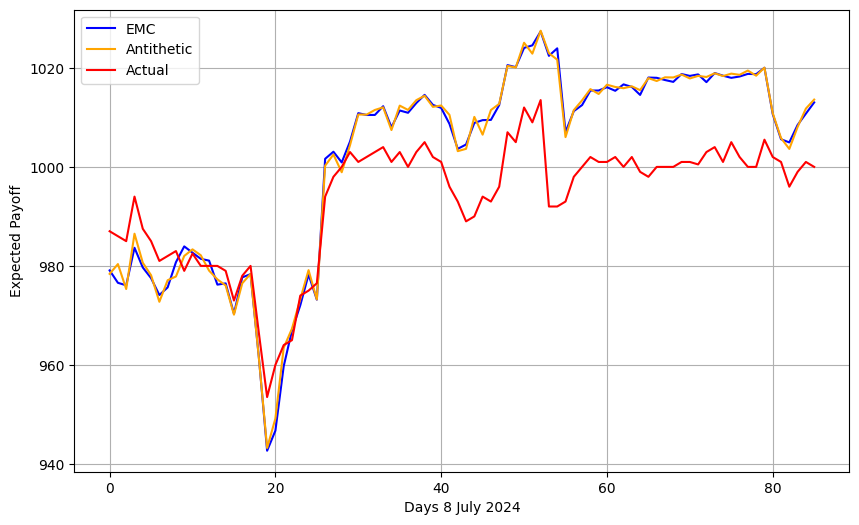

In [27]:
Nsim = 10000
Msim = 5000
results_emc, results_an = simulate_payoffs(Nsim, Msim, underlying_asset_data, risk_free_rate_series)

# Plot the payoffs
plt.figure(figsize=(10, 6))
plt.plot(results_emc, label = "EMC", color = "blue")
plt.plot(results_an, label = "Antithetic", color = "orange")
plt.plot(results_actual, label = "Actual", color = "red")
plt.xlabel('Days 8 July 2024')
plt.ylabel('Expected Payoff')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
options_data = pd.read_excel("/content/option data.xlsx")

In [28]:
# Heston model with calibration
reference_settlement_date = ql.Date(15, ql.June, 2023) # common reference date, set as 15 June 2023
ql.Settings.instance().evaluationDate = reference_settlement_date

# Initial heston model parameter guess
v0 = 0.1    # initial variance
kappa = 1.0  # Speed of mean reversion
theta = 0.1  # Long-run variance
sigma = 0.1  # Volatility of variance
rho = -0.5   # Correlation between dW1 and dW2

r = risk_free_rate_series[5] # risk free rate on 15 June 2023
calendar = ql.NullCalendar()
day_count = ql.Actual365Fixed()
flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(reference_settlement_date, r, day_count))
dividend_ts = ql.YieldTermStructureHandle(ql.FlatForward(reference_settlement_date, 0.0, day_count))

heston_process = ql.HestonProcess(flat_ts, dividend_ts,
                                  ql.QuoteHandle(ql.SimpleQuote(initial_price)),
                                  v0, kappa, theta, sigma, rho)
heston_model = ql.HestonModel(heston_process)
engine = ql.AnalyticHestonEngine(heston_model)

In [29]:
# Use maturity in years, calculated in option data
def heston_option_price(strike, maturity_in_years):
    payoff = ql.PlainVanillaPayoff(ql.Option.Call, strike)
    # Convert maturity in years to a Period in QuantLib
    exercise = ql.EuropeanExercise(reference_settlement_date + ql.Period(int(maturity_in_years * 365), ql.Days))
    option = ql.VanillaOption(payoff, exercise)
    option.setPricingEngine(engine)
    return option.NPV()

# Objective function for calibration
def objective(params):
    kappa, theta, sigma, rho, v0 = params
    heston_model.setParams([kappa, theta, sigma, rho, v0])

    # Calculate total squared error between model and market prices
    total_error = 0.0
    for _, row in options_data.iterrows():
        maturity_in_years = row['Maturity']  # time to maturity in years
        strike = row['Strike']
        market_price = row['Mid']
        if maturity_in_years > 0:
            model_price = heston_option_price(strike, maturity_in_years)
            total_error += (model_price - market_price) ** 2
    return total_error

# Initial parameter guess
initial_params = [kappa, theta, sigma, rho, v0]

# Calibration using SciPy minimize function
result = minimize(objective, initial_params, method='L-BFGS-B',
                  bounds=[(0.01, 5.0), (0.01, 1.0), (0.01, 2.0), (-1.0, 1.0), (0.01, 2.0)])

In [30]:
calibrated_params = result.x
kappa_cal, theta_cal, sigma_cal, rho_cal, v0_cal = calibrated_params

print("Calibrated Heston Parameters:")
print(f"kappa: {kappa_cal}")
print(f"theta: {theta_cal}")
print(f"sigma: {sigma_cal}")
print(f"rho: {rho_cal}")
print(f"v0: {v0_cal}")

Calibrated Heston Parameters:
kappa: 0.01000068076654747
theta: 0.01
sigma: 2.0
rho: 0.9991020764012838
v0: 0.020048714393349668


In [31]:
def heston_with_calibration(Nsim, S0_window, r, kappa, theta, sigma, rho, v0, T_minus_t):
    dt = 1 / 252
    steps = T_minus_t

    # Initialize paths for asset price and volatility
    S_paths = np.zeros((Nsim, steps + 1))
    v_paths = np.zeros((Nsim, steps + 1))
    S_paths[:, 0] = S0_window
    v_paths[:, 0] = v0

    # Generate random variables
    Z1 = np.random.normal(0, 1, (Nsim, steps))  # asset price
    Z2 = np.random.normal(0, 1, (Nsim, steps))  # volatility
    W1 = Z1
    W2 = rho * Z1 + np.sqrt(1 - rho ** 2) * Z2  # Correlated with W1

    for t in range(1, steps + 1):
        # Ensure non-negativity for variance paths
        v_paths[:, t] = np.abs(v_paths[:, t - 1] + kappa * (theta - v_paths[:, t - 1]) * dt +
                               sigma * np.sqrt(v_paths[:, t - 1] * dt) * W2[:, t - 1])
        # Update price path
        S_paths[:, t] = S_paths[:, t - 1] * np.exp((r - 0.5 * v_paths[:, t - 1]) * dt +
                                                   np.sqrt(v_paths[:, t - 1] * dt) * W1[:, t - 1])

    S_corrected = np.zeros_like(S_paths)
    S_corrected[:, 0] = S0_window
    for j in range(1, steps + 1):
        Z_matrix = S_corrected[:, j - 1] * S_paths[:, j] / S_paths[:, j - 1]
        correction_factor = np.exp(-r * (j * dt)) * np.mean(Z_matrix)
        S_corrected[:, j] = S0_window * Z_matrix / correction_factor

    return S_corrected, v_paths

In [32]:
def simulate_heston_calibrated_payoffs(Nsim, underlying_asset_data, risk_free_rate_series, total_days, window_size, T,
                            coupon_dates, monitoring_dates, barrier_level, initial_price, conversion_ratio, INITIAL_INVESTMENT,
                            kappa, theta, sigma, rho, v0):
    results_heston_calibrated = []
    max_i = total_days - window_size

    for i in range(max_i, -1, -1):
        drift, unnecessary_sigma, latest_price, risk_free_rate = get_sliding_window_params(
            underlying_asset_data, risk_free_rate_series, i, total_days
        )
        T_minus_t = T - (total_days - i)

        adjusted_coupon_dates = [date - (total_days - i) for date in coupon_dates]
        adjusted_monitoring_dates = [date - (total_days - i) for date in monitoring_dates]

        paths_heston_calibrated, _ = heston_with_calibration(Nsim, latest_price, risk_free_rate, kappa, theta, sigma, rho, v0, T_minus_t)
        expected_payoff_heston_calibrated = calculate_discounted_payoff(paths_heston_calibrated, barrier_level, initial_price, conversion_ratio,
                                                   risk_free_rate, T_minus_t,
                                 adjusted_coupon_dates, adjusted_monitoring_dates, initial_investment=INITIAL_INVESTMENT)
        results_heston_calibrated.append(expected_payoff_heston_calibrated)

    return results_heston_calibrated

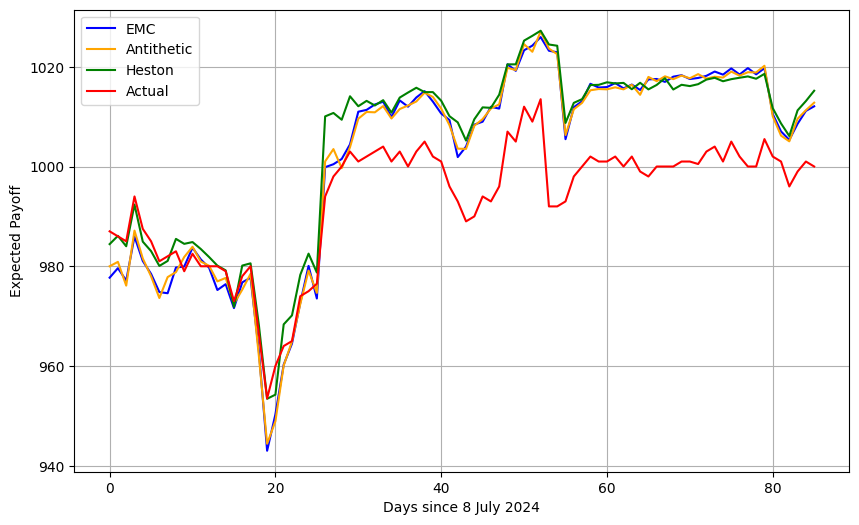

In [33]:
Nsim = 10000
Msim = 5000

results_emc, results_an = simulate_payoffs(Nsim, Msim, underlying_asset_data, risk_free_rate_series)
results_heston_calibrated = simulate_heston_calibrated_payoffs(Nsim, underlying_asset_data, risk_free_rate_series, TOTAL_DAYS,
                                         WINDOW_SIZE, T, coupon_dates,
                                         monitoring_dates, barrier_level,
                                         initial_price, conversion_ratio,
                                         INITIAL_INVESTMENT, kappa, theta,
                                         sigma, rho, v0)

# Plot expected payoffs
plt.figure(figsize=(10, 6))
plt.plot(results_emc, label="EMC", color = "blue")
plt.plot(results_an, label="Antithetic", color = "orange")
plt.plot(results_heston_calibrated, label="Heston", color = "green")
plt.plot(results_actual, label="Actual", color = "red")
plt.xlabel('Days since 8 July 2024')
plt.ylabel('Expected Payoff')
plt.grid(True)
plt.legend()
plt.show()

In [34]:
# Heston Model for Sequential Importance Resampling
def initialize_particles(N_particles):
    particles_v = np.random.normal(0.1, 0.01, N_particles)
    particles_v = np.maximum(particles_v, 1e-8)  # Ensure positive volatility
    particles_kappa = np.random.uniform(0.005, 0.015, N_particles)
    particles_theta = np.random.uniform(0.005, 0.015, N_particles)
    particles_xi = np.random.uniform(1.5, 2.5, N_particles)  # Ensure positive volatility of volatility
    particles_rho = np.random.uniform(-0.6, 1.0, N_particles)
    weights = np.ones(N_particles) / N_particles  # Equal initial weights
    return particles_v, particles_kappa, particles_theta, particles_xi, particles_rho, weights

def optimal_importance_function(particles_v_prev, yk, yk_prev, particles_kappa, particles_theta,
    particles_xi, particles_rho, dt, μ_S):
    # Discretized dynamics for vk, following the paper
    Δy = yk - yk_prev
    μ_S_array = np.full_like(particles_v_prev, μ_S)
    # Compute mean and variance for the proposal distribution p(vk | vk-1, yk)
    m = (particles_v_prev +
         particles_kappa * (particles_theta - particles_v_prev) * dt -
         particles_xi * particles_rho * (μ_S_array - 0.5 * particles_v_prev) * dt +
         particles_xi * particles_rho * Δy)
    var = (particles_xi ** 2 * particles_v_prev * (1 - particles_rho ** 2) * dt)
    var = np.maximum(var, 1e-8)  # Positive variance
    particles_v_new = m + np.sqrt(var) * np.random.normal(size=N_particles)  # Sample from Gaussian proposal distribution
    particles_v_new = np.maximum(particles_v_new, 1e-8)  # Ensure positive
    return particles_v_new

def update_weights(particles_v, yk, yk_prev, weights, dt, μ_S):
    # Likelihood function p(yk | vk, vk-1, yk-1)
    mean = yk_prev + (μ_S - 0.5 * particles_v) * dt
    variance = particles_v * dt
    variance = np.maximum(variance, 1e-8)
    likelihoods = (1 / np.sqrt(2 * np.pi * variance)) * np.exp(- (yk - mean) ** 2 / (2 * variance))
    weights *= likelihoods
    weights_sum = np.sum(weights)
    if weights_sum == 0 or np.isnan(weights_sum):
        weights = np.ones(N_particles) / N_particles
    else:
        weights /= weights_sum  # Normalize weights
    return weights

def resample_particles(weights):
    indices = np.random.choice(range(N_particles), N_particles, p=weights)
    return indices

def sequential_importance_resampling(y_series, N_particles, dt, μ_S):
    param_estimates = []
    v_estimates = []
    particles_v, particles_kappa, particles_theta, particles_xi, particles_rho, weights = initialize_particles(N_particles)
    for k in range(1, len(y_series)):
        yk = float(y_series[k])
        yk_prev = float(y_series[k-1])
        # Propagate particles
        particles_v = optimal_importance_function(
            particles_v, yk, yk_prev,
            particles_kappa, particles_theta, particles_xi, particles_rho, dt, μ_S
        )
        # Update weights based on observation likelihood
        weights = update_weights(particles_v, yk, yk_prev, weights, dt, μ_S)
        # Check for resampling
        effective_sample_size = 1.0 / np.sum(weights ** 2)
        if effective_sample_size < N_particles / 2:
            indices = resample_particles(weights)
            particles_v = particles_v[indices]
            particles_kappa = particles_kappa[indices]
            particles_theta = particles_theta[indices]
            particles_xi = particles_xi[indices]
            particles_rho = particles_rho[indices]
            weights = np.ones(N_particles) / N_particles
            # Enforce positive parameters
            particles_kappa = np.maximum(particles_kappa, 1e-8)
            particles_theta = np.maximum(particles_theta, 1e-8)
            particles_xi = np.maximum(particles_xi, 1e-8)

        # Parameter estimation by weighted average
        kappa_est = np.average(particles_kappa, weights=weights)
        theta_est = np.average(particles_theta, weights=weights)
        xi_est = np.average(particles_xi, weights=weights)
        rho_est = np.average(particles_rho, weights=weights)
        v_est = np.average(particles_v, weights=weights)
        param_estimates.append((kappa_est, theta_est, xi_est, rho_est))
        v_estimates.append(v_est)

    return param_estimates, v_estimates

In [35]:
def simulate_heston_sir_payoffs(Nsim, underlying_asset_data, risk_free_rate_series, total_days, window_size, T,
                                coupon_dates, monitoring_dates, barrier_level, initial_price, conversion_ratio, INITIAL_INVESTMENT):
    results_heston_sir = []
    max_i = total_days - window_size

    for i in range(max_i, -1, -1):
        start_idx = max(0, total_days - window_size - i)
        end_idx = total_days - i
        window_data = underlying_asset_data.iloc[start_idx:end_idx]
        log_returns_window = np.log(window_data / window_data.shift(1)).dropna()
        log_returns_window = np.array(log_returns_window, dtype=np.float64)
        y_series = np.cumsum(log_returns_window)
        y_series = np.insert(y_series, 0, 0)  # Cumulative log price
        μ_S = log_returns_window.mean()

        param_estimates, _ = sequential_importance_resampling(y_series, N_particles, dt, μ_S) # get estimated heston parameters with SIR
        kappa_estimates, theta_estimates, xi_estimates, rho_estimates = zip(*param_estimates)
        burn_in = int(0.1 * len(kappa_estimates))  # Exclude first 10% of estimates
        kappa = np.mean(kappa_estimates[burn_in:])
        theta = np.mean(theta_estimates[burn_in:])
        sigma = np.mean(xi_estimates[burn_in:])
        rho = np.mean(rho_estimates[burn_in:])

        # Use get_sliding_window_params to get other parameters
        drift, _, latest_price, risk_free_rate = get_sliding_window_params(
            underlying_asset_data, risk_free_rate_series, i, total_days
        )

        T_minus_t = T - (total_days - i)
        adjusted_coupon_dates = [date - (total_days - i) for date in coupon_dates]
        adjusted_monitoring_dates = [date - (total_days - i) for date in monitoring_dates]

        # Generate paths and get expected payoff
        v0 = 0.1  # Initial variance
        paths_heston_sir, _ = heston_with_calibration(Nsim, latest_price, risk_free_rate, kappa, theta, sigma, rho, v0, T_minus_t)
        expected_payoff_heston_sir = calculate_discounted_payoff(paths_heston_sir, barrier_level, initial_price, conversion_ratio,
                                                   risk_free_rate, T_minus_t,
                                                   adjusted_coupon_dates, adjusted_monitoring_dates, initial_investment=INITIAL_INVESTMENT)

        # Store the result
        results_heston_sir.append(expected_payoff_heston_sir)

    return results_heston_sir

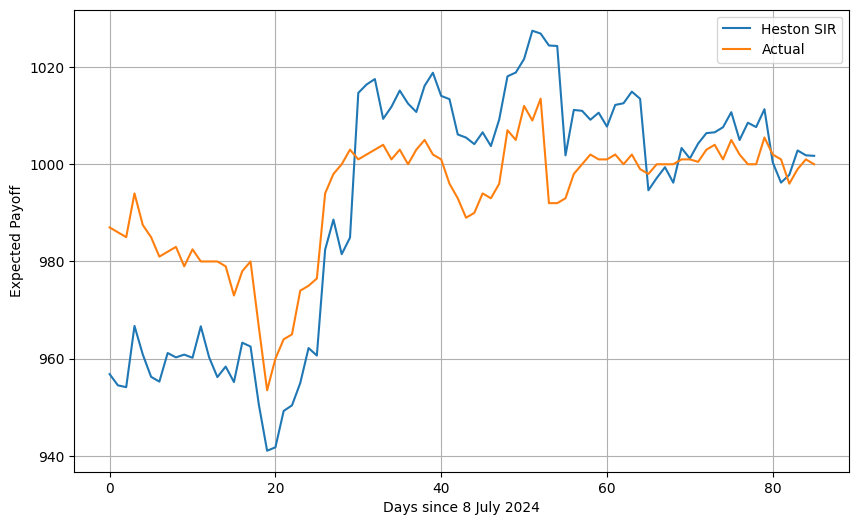

In [36]:
N_particles = 10000
Nsim = 10000
dt = 1 / 252  # Daily time step
results_heston_sir = simulate_heston_sir_payoffs(Nsim, underlying_asset_data, risk_free_rate_series, TOTAL_DAYS,
                                         WINDOW_SIZE, T, coupon_dates,
                                         monitoring_dates, barrier_level,
                                         initial_price, conversion_ratio,
                                         INITIAL_INVESTMENT)

# Plot expected payoffs
plt.figure(figsize=(10, 6))
plt.plot(results_heston_sir, label="Heston SIR")
plt.plot(results_actual, label="Actual")
plt.xlabel('Days since 8 July 2024')
plt.ylabel('Expected Payoff')
plt.grid(True)
plt.legend()
plt.show()

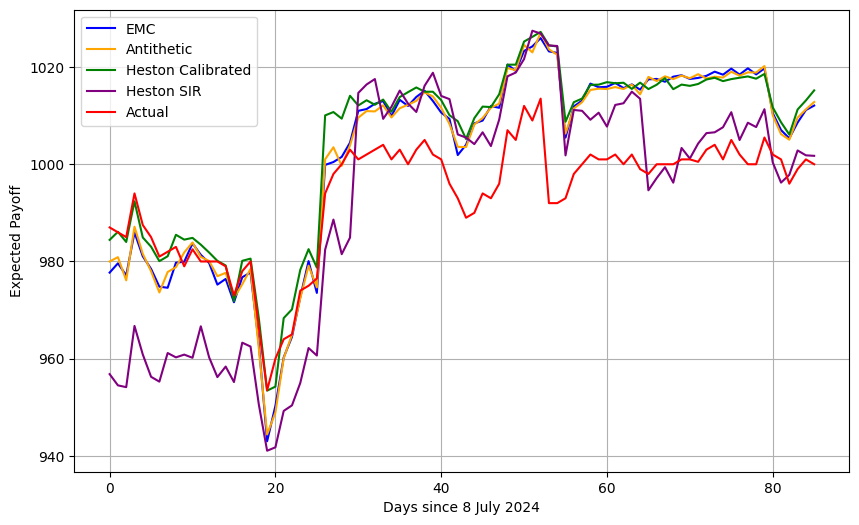

In [37]:
# Plot the expected payoffs
plt.figure(figsize=(10, 6))
plt.plot(results_emc, label="EMC", color = "blue")
plt.plot(results_an, label="Antithetic", color = "orange")
plt.plot(results_heston_calibrated, label="Heston Calibrated", color = "green")
plt.plot(results_heston_sir, label="Heston SIR", color = "purple")
plt.plot(results_actual, label="Actual", color = "red")
plt.xlabel('Days since 8 July 2024')
plt.ylabel('Expected Payoff')
plt.grid(True)
plt.legend()
plt.show()

In [38]:
def compute_mse(results, actual_prices):
    results = np.array(results)
    mse = np.mean((results - actual_prices) ** 2)
    return mse

In [39]:
print(f"MSE of gbm with emc: {compute_mse(results_emc, results_actual)}")
print(f"MSE of gbm with Antithetic Variable: {compute_mse(results_an, results_actual)}")
print(f"MSE of gbm with Heston Model through Calibration: {compute_mse(results_heston_calibrated, results_actual)}")
print(f"MSE of gbm with Heston Model with Sequential Importance Sampling: {compute_mse(results_heston_sir, results_actual)}")

MSE of gbm with emc: 155.74464967469513
MSE of gbm with Antithetic Variable: 152.83946687580894
MSE of gbm with Heston Model through Calibration: 167.71264529780015
MSE of gbm with Heston Model with Sequential Importance Sampling: 238.24961495690857
